In [1]:
#==================================================================
#EXTERNAL SLADS SETUP
#==================================================================

#==================================================================
#GENERAL LIBRARY IMPORTS
#==================================================================
from __future__ import absolute_import, division, print_function
import cv2
import contextlib
import copy
import datetime
import gc
import glob
import logging
import math
import matplotlib
import matplotlib.pyplot as plt
import multiplierz
import multiprocessing
import natsort
import numpy as np
import numpy.matlib as matlib
import os
import pandas as pd
import pickle
import PIL
import PIL.ImageOps
import platform
import ray
import re
import sys
import scipy
import shutil
import sklearn
import time
import warnings

from IPython import display
from IPython.core.debugger import Tracer
from itertools import chain
from joblib import Parallel, delayed
from matplotlib.pyplot import figure
from multiplierz.mzAPI import mzFile
from multiplierz.spectral_process import mz_range
from numba import jit
from PIL import Image
from scipy import misc
from scipy import signal
from scipy.io import loadmat
from scipy.io import savemat
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks
from scipy.special import softmax
from sklearn import linear_model
from sklearn import svm
from sklearn.kernel_approximation import RBFSampler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import NearestNeighbors
from sklearn.neural_network import MLPRegressor as nnr
from sklearn.preprocessing import *
from sklearn.utils import shuffle
from skimage.util import view_as_windows as viewW
from skimage import filters
from skimage.filters import *
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity
from skimage.transform import resize
from sobol import *
from tqdm.auto import tqdm

import skimage
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.datasets import load_digits

ray.init()

2021-07-24 19:51:17,555	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '134.48.232.100',
 'raylet_ip_address': '134.48.232.100',
 'redis_address': '134.48.232.100:6379',
 'object_store_address': 'tcp://127.0.0.1:62428',
 'raylet_socket_name': 'tcp://127.0.0.1:61148',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\YATAGA~1\\AppData\\Local\\Temp\\ray\\session_2021-07-24_19-51-11_394993_21652',
 'metrics_export_port': 63409,
 'node_id': 'ea8c477fb5443c4faee600c2b9ae2f1ebc2779d11b909e0b1f5376ae'}

In [2]:
@ray.remote
def pxData_parhelper(scanFileName, pxNum):
    return mzFile(scanFileName).scan(pxNum, centroid=True)

def pxDataBin(scanFileName, pxNum, mzLocations, mzMin, mzMax):
    spec = np.asarray(mzFile(scanFileName).scan(pxNum, centroid=True))
    return scipy.stats.binned_statistic(spec[:,0], spec[:,1], statistic='sum', bins=mzLocations, range=[mzMin, mzMax])[0][np.arange(0,len(mzLocations)-1,2)].tolist()

@jit(nopython=True)
def indexFinder(spectrum, index, mzLeftRanges, mzRightRanges, count):
    
    #Determine left and right most points within the bounds of the peak
    leftIndex, rightIndex = index, index
    while mzRightRanges[leftIndex] >= mzLeftRanges[index] and leftIndex > 0: leftIndex-=1
    while mzLeftRanges[rightIndex] <= mzRightRanges[index] and rightIndex < len(spectrum)-1: rightIndex+=1
    
    #Increase count of captured points
    count += np.sum(spectrum[:,1][leftIndex:rightIndex+1]>0)
    
    #Remove points in range from further consideration
    spectrum[:,1][leftIndex:rightIndex+1] = 0

    #Identify the next location
    index = np.argmax(spectrum[:,1])
    
    return spectrum, index, count

@ray.remote
def readFile(scanFileName, origScanTimes, newScanTimes, mzLocations, mzIndexes, mzMin, mzMax):
    
    #Scan each of the pixels in the file
    colData = np.asarray([pxDataBin(scanFileName, pxNum, mzLocations, mzMin, mzMax) for pxNum in np.arange(1, mzFile(scanFileName).scan_range()[1]+1)]).flatten()
    
    #Interpolate all m/z according to new times so as to geometrically realign rows
    return scipy.interpolate.interp2d(origScanTimes, mzIndexes, colData, kind='linear')(newScanTimes,mzIndexes).T
    
@ray.remote
def scoring_parhelper(filterSquareTIC, thresholdImage, mzImage):
    
    #Determine foreground and background IOU
    mzThresholdImage = mzImage>skimage.filters.threshold_otsu(mzImage)
    goodIOU = np.sum(np.logical_and(mzThresholdImage, thresholdImage)) / np.sum(np.logical_or(mzThresholdImage, thresholdImage))
    badIOU = np.sum(np.logical_and(mzThresholdImage, 1-thresholdImage)) / np.sum(np.logical_or(mzThresholdImage, 1-thresholdImage))

    return goodIOU-badIOU



Slide1-Wnt3


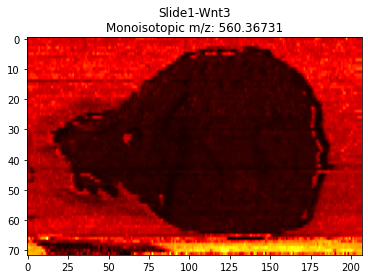

Merge Spectra:   0%|          | 0/72 [00:00<?, ?it/s]

# of raw mz : 4972973


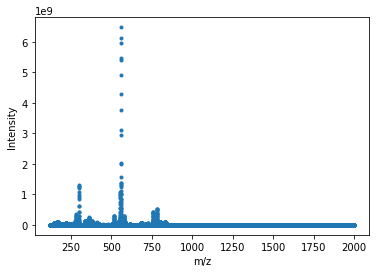

Processed mz:   0%|          | 0/4972973 [00:00<?, ?it/s]

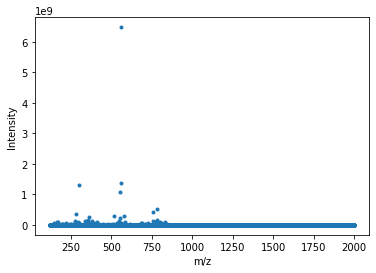

# of mz Bins: 51039
mz Image Extraction Time: 85.59785532951355


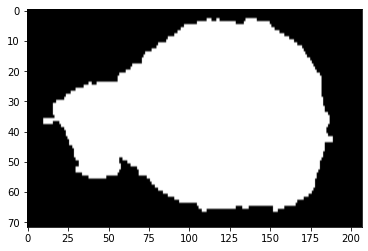

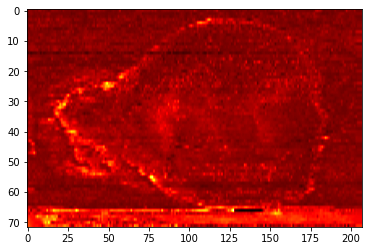

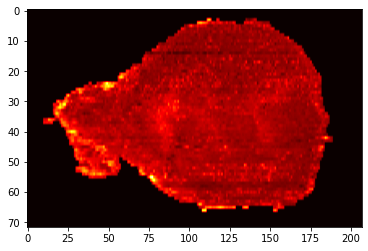

Scoring:   0%|          | 0/51039 [00:00<?, ?it/s]

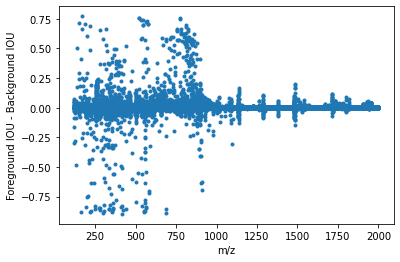

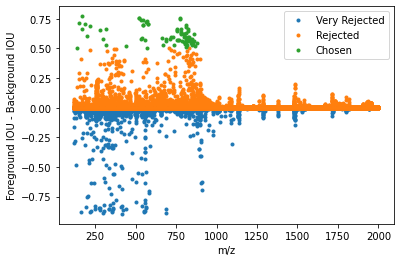

# of Chosen Locations: 79
# of Rejected Locations: 28707
# of Worst Locations: 22253


Mosaic:   0%|          | 0/79 [00:00<?, ?it/s]

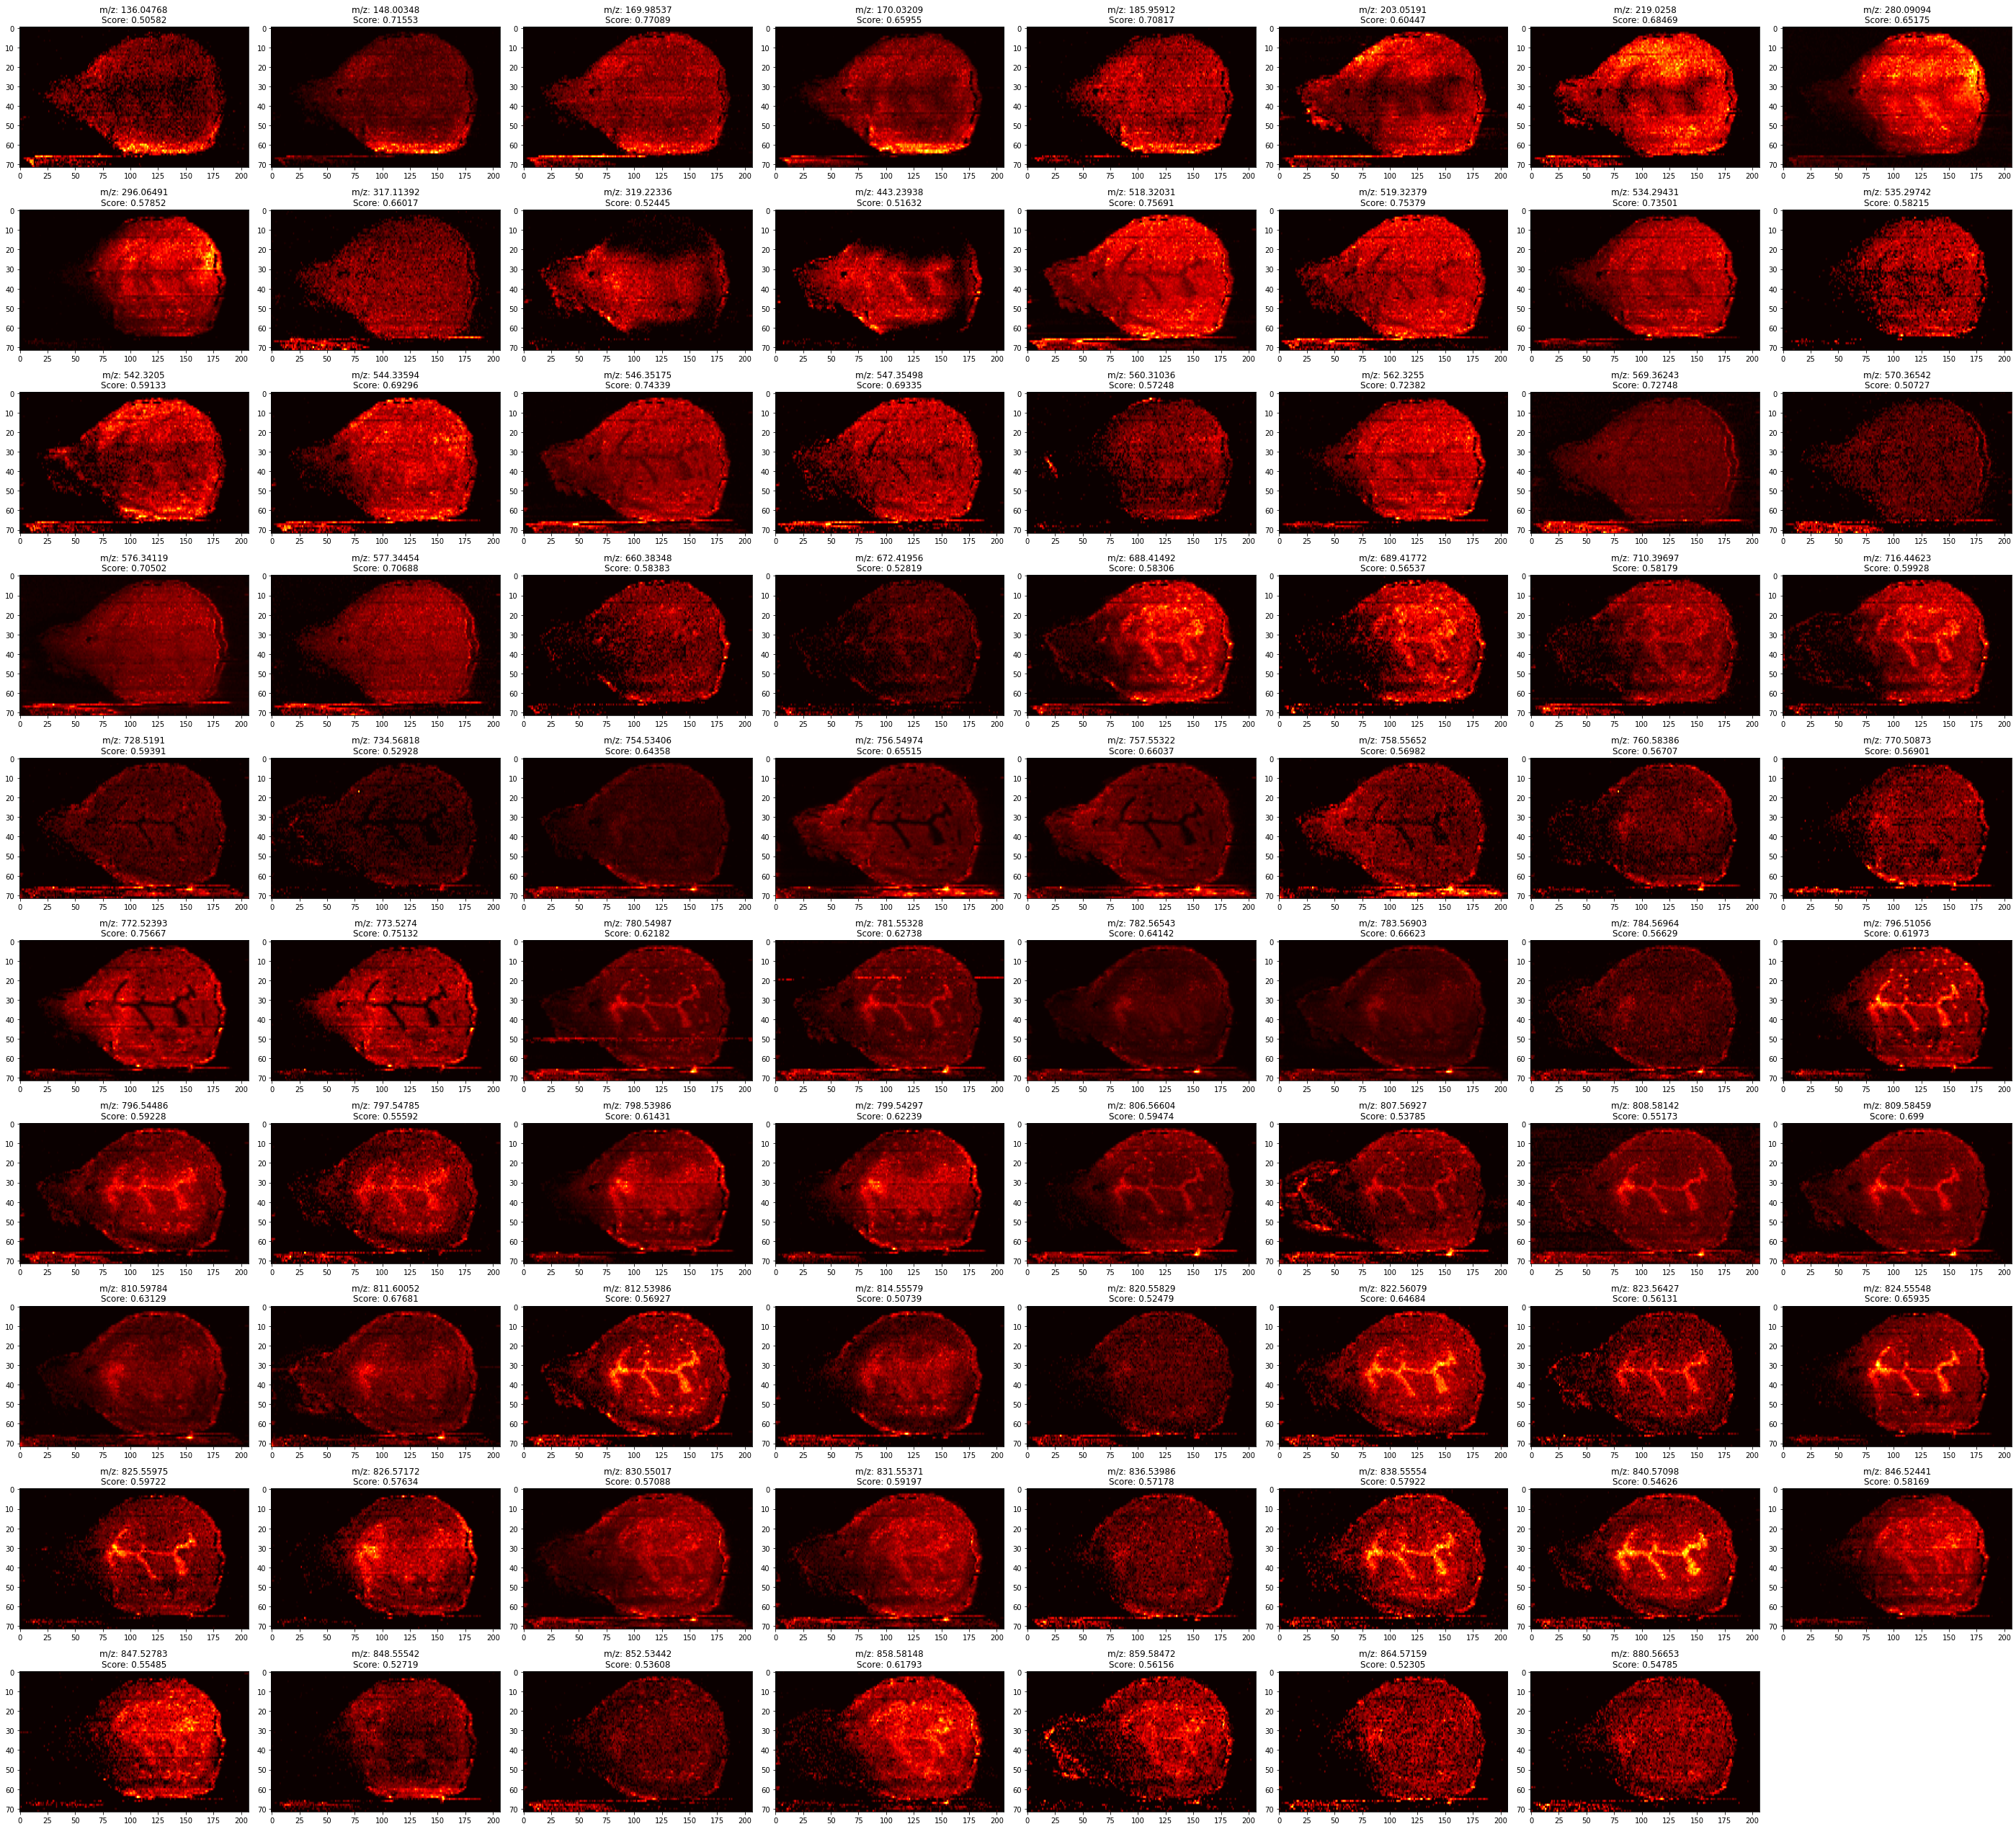

<ipython-input-3-e45025098cb1>:314: DeprecationWarning: `Tracer` is deprecated since version 5.1, directly use `IPython.core.debugger.Pdb.set_trace()`
  Tracer()()


> <ipython-input-3-e45025098cb1>(315)<module>()
    313 
    314     Tracer()()
--> 315     np.savetxt(sampleName+'_worst.csv', [peakList[:,0][worstScoreLocations],scores[worstScoreLocations]], delimiter=',')
    316     np.savetxt(sampleName+'_reject.csv', [peakList[:,0][rejectedScoreLocations],scores[rejectedScoreLocations]], delimiter=',')
    317     np.savetxt(sampleName+'_chosen.csv', [peakList[:,0][chosenScoreLocations],scores[chosenScoreLocations]], delimiter=',')

ipdb> exit
Exiting Debugger.


In [3]:
totalData, totalThresholdImages, totalmzLocations, totalChosenScores, totalChosenLocations, totalWorstLocations, totalRejectedLocations, sampleNames = [], [], [], [], [], [], [], []
mzMinGlobal, mzMaxGlobal = np.inf, -np.inf
globalNewTimes, globalOrigTimes, globalScanFiles = [], [], []

#Obtain sample directories
sampleFolders = natsort.natsorted(glob.glob('./INPUTS-ut/*'), reverse=False)

#For each of the identified samples, isolate most prominent mz, and those that are geometrically signficant
#sampleFolder = sampleFolders[0]
for sampleFolder in sampleFolders:
    sampleName = sampleFolder.split(os.path.sep)[-1]
    sampleNames.append(sampleName)
    print('\n\n'+sampleName)

    extensions = list(map(lambda x:x, np.unique([filename.split('.')[-1] for filename in natsort.natsorted(glob.glob(sampleFolder+os.path.sep+'*'), reverse=False)])))
    if 'd' in extensions: lineExt = '.d'
    elif 'D' in extensions: lineExt = '.D'
    elif 'raw' in extensions: lineExt = '.raw'
    elif 'RAW' in extensions: lineExt = '.RAW'
    else: sys.exit('Error! - Either no MSI files are present, or an unknown MSI filetype being used for sample: ' + self.name)

    #Read in data from sampleInfo.txt
    lineIndex = 0
    sampleInfo = open(sampleFolder+os.path.sep+'sampleInfo.txt').readlines()

    #Read the max number of lines that are expected 
    numLines = int(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read the sample width
    sampleWidth = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read the sample height
    sampleHeight = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read in scan rate
    scanRate = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read in monoisotopic mz
    mzMono = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read in minimum mz
    mzMin = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read in maximum mz
    mzMax = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read window tolerance (ppm)
    ppm = float(sampleInfo[lineIndex].rstrip())*1e-6
    lineIndex += 1

    #Read FT resolution to set precision
    resFT = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Process the read information
    ppmPos, ppmNeg = 1+ppm, 1-ppm
    mzResOrder = round(np.log10(resFT))
    mzInvRes = pow(10, round(np.log10(resFT)))
    mzRes = pow(10, round(np.log10(1/resFT)))
    mzMonoRange = [mzMono*ppmNeg, mzMono*ppmPos]
    binSize = round((mzMin*ppmPos)-(mzMin*ppmNeg),5)
    
    #Check global condition of specified min and max mz
    if mzMin<mzMinGlobal: mzMinGlobal = mzMin
    if mzMax>mzMaxGlobal: mzMaxGlobal = mzMax
    
    finalWidth = int(round((sampleWidth*1e3)/scanRate))
    newTimes = np.linspace(0, (finalWidth-1)/60, finalWidth)

    #Get paths for raw data files
    scanFiles = natsort.natsorted(glob.glob(sampleFolder+os.path.sep+'*'+lineExt), reverse=False)

    #Get original timing information
    dataFiles = [mzFile(scanFileName) for scanFileName in scanFiles]
    origTimes = [np.asarray(data.xic(data.time_range()[0], data.time_range()[1]))[:,0] for data in dataFiles]
    
    #Obtain and square TIC for reference
    origTIC = [np.asarray(data.xic(data.time_range()[0], data.time_range()[1]))[:,1] for data in dataFiles]
    squareTIC = np.asarray([np.interp(newTimes, origTimes[lineNum], origTIC[lineNum]) for lineNum in range(0, len(origTIC))])

    #Obtain and square monoisotopic for reference
    origMono = [np.asarray(data.xic(data.time_range()[0], data.time_range()[1], mzMonoRange[0], mzMonoRange[1]))[:,1] for data in dataFiles]
    squareMono = np.asarray([np.interp(newTimes, origTimes[lineNum], origMono[lineNum]) for lineNum in range(0, len(origMono))])

    globalNewTimes.append(newTimes)
    globalOrigTimes.append(origTimes)
    globalScanFiles.append(scanFiles)
    
    plt.imshow(squareMono, aspect='auto', cmap='hot')
    plt.title(sampleName+'\nMonoisotopic m/z: ' + str(mzMono))
    plt.savefig('mzMono-'+sampleName+'-mz-'+str(mzMono)+'.png')
    plt.show()
    plt.close()

    #Merge spectra in all sample pixels
    pxData = []
    scanFiles = natsort.natsorted(glob.glob(sampleFolder+os.path.sep+'*'+lineExt), reverse=False)
    for scanFileName in tqdm(scanFiles, desc='Merge Spectra'):
        temp = ray.get([pxData_parhelper.remote(scanFileName, scanNum) for scanNum in range(1, mzFile(scanFileName).scan_range()[1]+1)])
        for item in temp: pxData+=item

    #Round according to resolution and find list of unique locations
    pxData = np.asarray(pxData)
    pxData[:,0] = np.round(pxData[:,0],5)
    unique, indexes = np.unique(pxData[:,0], return_inverse=True)

    #Sum intensities at identical locations
    sums = np.zeros(len(unique))
    np.add.at(sums, indexes, pxData[:,1])

    #Sort and recombine
    sortedIndexes = np.argsort(unique)
    spectrum = np.column_stack((unique[sortedIndexes], sums[sortedIndexes]))
    print('# of raw mz : ' + str(len(spectrum)))

    plt.plot(spectrum[:,0], spectrum[:,1], '.')
    plt.xlabel('m/z')
    plt.ylabel('Intensity')
    plt.savefig('mzDistribution-'+sampleName+'.png')
    plt.show()
    plt.close()
    
    #Determine left and right hand bin boundaries for each point, account for min/max mz
    mzLeftRanges, mzRightRanges = spectrum[:,0]*ppmNeg, spectrum[:,0]*ppmPos
    mzLeftRanges[mzLeftRanges<mzMin] = mzMin
    mzRightRanges[mzRightRanges>mzMax] = mzMax

    #Bin data around peaks, removing mz window overlap for specified ppm
    count = 0
    peakList=[]
    origLen=len(spectrum)
    index = np.argmax(spectrum[:,1])
    firstFlag = True
    with tqdm(total = origLen, desc = 'Processed mz', leave = True, ascii=True) as pbar:
        while index!=0 or firstFlag:

            #Turn off flag for future loops
            firstFlag=False

            #Add point to list of peaks
            peakList.append(spectrum[index].tolist())

            spectrum, index, count = indexFinder(spectrum, index, mzLeftRanges, mzRightRanges, count)

            #Update progress bar
            pbar.n = count
            pbar.refresh()

    peakList= np.asarray(peakList)
    peakList = peakList[np.argsort(peakList[:,0])]
    plt.plot(peakList[:,0], peakList[:,1],'.')
    plt.xlabel('m/z')
    plt.ylabel('Intensity')
    plt.savefig('mzDistributionBinned-'+sampleName+'.png')
    plt.show()
    plt.close()
    print('# of mz Bins: ' + str(len(peakList)))

    #Check to make sure that no bins are overlapping! - Keep for debugging
    #sortedIndexes = np.argsort(peakList[:,0])
    #test = peakList[sortedIndexes][:,0]
    #testBinRanges = np.round(np.column_stack((test*ppmNeg, test*ppmPos)),5)
    #diff = [testBinRanges[index+1][0]-testBinRanges[index][1] for index in range(0, len(testBinRanges)-1)]
    #print('Overlapping bin(s): ' + str(np.where(np.asarray(diff)<0)))

    mzRanges = np.round(np.column_stack((peakList[:,0]*ppmNeg, peakList[:,0]*ppmPos)),5)
    mzLocations = mzRanges.flatten()
    mzIndexes = np.arange(0, len(mzLocations)/2)

    t0 = time.time()
    fullData = ray.get([readFile.remote(scanFiles[fileNum], origTimes[fileNum], newTimes, mzLocations, mzIndexes, mzMin, mzMax) for fileNum in range(0, len(scanFiles))])
    fullData = np.asarray(fullData)
    print('mz Image Extraction Time: ' + str(time.time()-t0))

    #Set final structure to be indexable and move m/z axis to be first
    fullData = np.moveaxis(fullData, -1, 0)

    #Normalize with minMax scaler (needed for SSIM range)
    fullData = (fullData-np.min(fullData))/(np.max(fullData)-np.min(fullData))

    
    #Generate rough geometrical representation of the sample based on monoisotopic image
    
    #Normalize TIC and monoisotopic 
    squareMono = (squareMono-np.min(squareMono))/(np.max(squareMono)-np.min(squareMono))
    squareTIC = (squareTIC-np.min(squareTIC))/(np.max(squareTIC)-np.min(squareTIC))

    #Remove most extreme low values to prevent exploding values
    bottom, top = np.percentile(squareMono, (1,100))
    squareMono[squareMono<=bottom] = bottom

    #Normalize the TIC by the monoisotopic and bias values for thesholding
    thresholdImage = squareTIC/squareMono
    bottom, top = np.percentile(thresholdImage, (40,70))
    thresholdImage[thresholdImage>=top] = top
    thresholdImage[thresholdImage<=bottom] = 0
    
    #Threshold image, erode/dilate, blur, and fill image to close small holes/openings
    thresholdImage = thresholdImage>skimage.filters.threshold_otsu(thresholdImage)
    thresholdImage = skimage.morphology.closing(thresholdImage, np.ones((1,3)))
    thresholdImage = scipy.ndimage.binary_fill_holes(thresholdImage)
    thresholdImage = skimage.filters.gaussian(thresholdImage)>=0.5
    
    #Isolate the largest structure in the binary image
    regions = skimage.measure.regionprops(skimage.measure.label(thresholdImage))
    chosen = regions[np.argmax([region.area for region in regions])]
    thresholdImage = np.zeros(thresholdImage.shape)
    thresholdImage[chosen.bbox[0]:chosen.bbox[2], chosen.bbox[1]:chosen.bbox[3]] = chosen.image

    #Plot the foreground mask
    plt.imshow(thresholdImage, aspect='auto', cmap='gray')
    plt.savefig('thresholdImage-'+sampleName+'.png')
    plt.show()
    plt.close()

    #Get the isolated TIC for SSIM comparison
    filterSquareTIC = thresholdImage*squareTIC
    
    #Plot the TIC
    plt.imshow(squareTIC, aspect='auto', cmap='hot')
    plt.savefig('TIC-'+sampleName+'.png')
    plt.show()
    plt.close()
    
    #Plot the image being used for SSIM comparison
    plt.imshow(filterSquareTIC, aspect='auto', cmap='hot')
    plt.savefig('foregroundTIC-'+sampleName+'.png')
    plt.show()
    plt.close()

    #Score the images based on SSIM relative to the thresholdImage
    #scores = np.asarray(ray.get([scoring_parhelper.remote(filterSquareTIC, thresholdImage, mzImage) for mzImage in fullData]))

    scores = []
    for mzImage in tqdm(fullData, desc='Scoring'):
        #Determine foreground and background IOU
        mzThresholdImage = mzImage>skimage.filters.threshold_otsu(mzImage)
        goodIOU = np.sum(np.logical_and(mzThresholdImage, thresholdImage)) / np.sum(np.logical_or(mzThresholdImage, thresholdImage))
        badIOU = np.sum(np.logical_and(mzThresholdImage, 1-thresholdImage)) / np.sum(np.logical_or(mzThresholdImage, 1-thresholdImage))
        scores.append(goodIOU-badIOU)
    scores = np.asarray(scores)

    
    #Plot the raw scores of images 
    plt.plot(peakList[:,0], scores,'.')
    plt.xlabel('m/z')
    plt.ylabel('Foreground IOU - Background IOU')
    plt.savefig('iouDistribution-'+sampleName+'.png')
    plt.show()
    plt.close()

    #Seperate m/z images; 0.5 generally considered 'good' threshold for IOU
    chosenScoreLocations = np.argwhere(scores>=0.5).flatten()
    worstScoreLocations = np.argwhere(scores<=0).flatten()
    rejectedScoreLocations = np.asarray(list(set(np.argwhere(scores).flatten()).difference(set(worstScoreLocations.flatten()).union(set(chosenScoreLocations.flatten())))))

    #Store information for later analysis over all samples
    totalData.append(fullData)
    totalThresholdImages.append(thresholdImage)
    totalChosenScores.append(scores[chosenScoreLocations])
    totalmzLocations.append(peakList[:,0])
    totalChosenLocations.append(chosenScoreLocations)
    totalWorstLocations.append(worstScoreLocations)
    totalRejectedLocations.append(rejectedScoreLocations)

    #Plot the distribution of images 
    if len(worstScoreLocations)>0: plt.plot(peakList[:,0][worstScoreLocations],scores[worstScoreLocations],'.',label='Very Rejected')
    if len(rejectedScoreLocations)>0: plt.plot(peakList[:,0][rejectedScoreLocations],scores[rejectedScoreLocations],'.',label='Rejected')
    if len(chosenScoreLocations)>0: plt.plot(peakList[:,0][chosenScoreLocations],scores[chosenScoreLocations],'.',label='Chosen')
    plt.legend()
    plt.xlabel('m/z')
    plt.ylabel('Foreground IOU - Background IOU')
    plt.savefig('iouDistributionSplit-'+sampleName+'.png')
    plt.show()
    plt.close()

    print('# of Chosen Locations: ' + str(len(chosenScoreLocations)))
    print('# of Rejected Locations: ' + str(len(rejectedScoreLocations)))
    print('# of Worst Locations: ' + str(len(worstScoreLocations)))

    #Plot chosen in mosaic/grid
    totalNumColumns = 8
    numRows = int(np.ceil(len(chosenScoreLocations)/totalNumColumns))
    f = plt.figure(figsize=(40, int((30*numRows)/totalNumColumns)))

    f.patch.set_facecolor('#FFFFFF')
    f.subplots_adjust(top = 0.95, bottom = 0.02, left=0.02, right=0.98)
    f.subplots_adjust(wspace=0.1, hspace=0.3)

    numRow, numColumn = 0, 0
    for mzLocation in tqdm(chosenScoreLocations, desc='Mosaic'):

        ax = plt.subplot2grid((numRows,totalNumColumns), (numRow,numColumn))
        ax.imshow(fullData[mzLocation], aspect='auto', cmap='hot')
        ax.set_title('m/z: '+str(peakList[:,0][mzLocation])+'\nScore: '+str(np.round(scores[mzLocation],5)))

        numColumn+=1
        if numColumn >= totalNumColumns:
            numColumn=0
            numRow+=1

    #plt.suptitle(sampleFolder.split('/')[-1], fontsize=15, fontweight='bold')
    plt.savefig('chosenImages-' + sampleName + '.png')
    plt.show()
    plt.close()
    
    np.savetxt(sampleName+'_worst.csv', np.transpose([peakList[:,0][worstScoreLocations],scores[worstScoreLocations]]), delimiter=',')
    np.savetxt(sampleName+'_reject.csv', np.transpose([peakList[:,0][rejectedScoreLocations],scores[rejectedScoreLocations]]), delimiter=',')
    np.savetxt(sampleName+'_chosen.csv', np.transpose([peakList[:,0][chosenScoreLocations],scores[chosenScoreLocations]]), delimiter=',')

#Get flat list of chosen mz locations and their scores for all samples
mzChosen = [totalmzLocations[index][totalChosenLocations[index]] for index in range(0, len(totalmzLocations))]
mzChosen = np.concatenate(mzChosen)
mzChosenScores = np.concatenate(totalChosenScores)

#Find which of the chosen mz have an overlap by specified ppm over all of the samples
overlapIndexes = [np.where((mzChosen*ppmPos>=mzValue*ppmNeg) & (mzChosen*ppmNeg<=mzValue*ppmPos))[0].tolist() for mzValue in mzChosen]
counts = np.asarray([len(item) for item in overlapIndexes])
indexes = counts>=len(totalChosenLocations)

#Find the average mz position/score for each subset
mzAverageChosen = np.round(np.asarray([np.mean(mzChosen[mzIndexes].tolist()) for mzIndexes in np.asarray(np.asarray(overlapIndexes, dtype='object')[indexes].tolist())]),5)
mzAverageScoresChosen = np.asarray([np.mean(mzChosenScores[mzIndexes].tolist()) for mzIndexes in np.asarray(np.asarray(overlapIndexes, dtype='object')[indexes].tolist())])

#Now do one final overlapping window elimination, use scores to differentiate
mzCommon = []
while len(mzAverageChosen)>0:
    index = np.argmax(mzAverageScoresChosen)
    overlapIndexes = np.where((mzAverageChosen*ppmPos>=mzAverageChosen[index]*ppmNeg) & (mzAverageChosen*ppmNeg<=mzAverageChosen[index]*ppmPos))[0]
    mzCommon.append(np.round(np.mean(mzAverageChosen[overlapIndexes]),5))
    mzAverageChosen = np.delete(mzAverageChosen, overlapIndexes)
    mzAverageScoresChosen = np.delete(mzAverageScoresChosen, overlapIndexes)
mzCommon = np.asarray(mzCommon)

#Sort in order and prepare for visualizations
mzCommon = mzCommon[np.argsort(mzCommon)]
mzCommonRanges = np.round(np.column_stack((mzCommon*ppmNeg,mzCommon*ppmPos)),5)
mzLocations = mzCommonRanges.flatten()
mzIndexes = np.arange(0, len(mzLocations)/2)
    
totalImages = []
for index in tqdm(range(0, len(sampleFolders))):
    
    sampleName = sampleNames[index]
    fullData = ray.get([readFile.remote(globalScanFiles[index][fileNum], globalOrigTimes[index][fileNum], globalNewTimes[index], mzLocations, mzIndexes, mzMinGlobal, mzMaxGlobal) for fileNum in range(0, len(globalScanFiles[index]))])
    fullData = np.asarray(fullData)
    fullData = np.moveaxis(fullData, -1, 0)
    fullData = (fullData-np.min(fullData))/(np.max(fullData)-np.min(fullData))
    
    #Plot chosen in mosaic/grid
    totalNumColumns = 8
    numRows = int(np.ceil(len(mzCommon)/totalNumColumns))
    f = plt.figure(figsize=(40, int((30*numRows)/8)))

    f.patch.set_facecolor('#FFFFFF')
    f.subplots_adjust(top = 0.95, bottom = 0.02, left=0.02, right=0.98)
    f.subplots_adjust(wspace=0.1, hspace=0.3)
    
    numRow, numColumn = 0, 0
    for index in tqdm(range(0, len(mzCommon)), desc='Sample Common mz'):
        
        totalImages.append(fullData[index])
        ax = plt.subplot2grid((numRows,totalNumColumns), (numRow,numColumn))
        ax.imshow(fullData[index], aspect='auto', cmap='hot')
        ax.set_title('m/z: '+str(mzCommon[index]))

        numColumn+=1
        if numColumn >= totalNumColumns:
            numColumn=0
            numRow+=1

    #plt.suptitle(sampleFolder.split('/')[-1], fontsize=15, fontweight='bold')
    plt.savefig('mzCommon-' + sampleName + '.png')
    plt.show()
    plt.close()
    
#Plot chosen in mosaic/grid
colLabels = ['m/z: {}'.format(col) for col in mzCommon]
rowLabels = ['{}'.format(row) for row in sampleNames]

totalNumColumns = len(mzCommon)
numRows = len(sampleNames)
f = plt.figure(figsize=(int(5*totalNumColumns), int((30*numRows)/8)))

f.patch.set_facecolor('#FFFFFF')
f.subplots_adjust(top = 0.95, bottom = 0.02, left=0.02, right=0.98)
f.subplots_adjust(wspace=0.1, hspace=0.3)
pad = 5
numRow, numColumn = 0, 0

for image in tqdm(totalImages):
    
    ax = plt.subplot2grid((numRows,totalNumColumns), (numRow,numColumn))
    ax.imshow(image, aspect='auto', cmap='hot')
    if numRow == 0: 
        ax.annotate(colLabels[numColumn], xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

        #ax.set_title(colLabels[numColumn], fontsize=15, fontweight='bold')
    if numColumn == 0: 
        ax.annotate(rowLabels[numRow], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        #ax.set_ylabel(rowLabels[numRow], rotation=0, size='large', fontsize=15, fontweight='bold')
    #ax.set_title('M/Z: '+str(np.round(mzLocations[location],4))+'-'+str(round(mzLocations[location]+window,4)))

    numColumn+=1
    if numColumn >= totalNumColumns:
        numColumn=0
        numRow+=1

f.tight_layout()
plt.savefig('finalChosenImages.png')
plt.show()
plt.close()


In [6]:
totalData, totalThresholdImages, totalmzLocations, totalChosenScores, totalChosenLocations, totalWorstLocations, totalRejectedLocations, sampleNames = [], [], [], [], [], [], [], []
mzMinGlobal, mzMaxGlobal = np.inf, -np.inf
globalNewTimes, globalOrigTimes, globalScanFiles = [], [], []

#Obtain sample directories
sampleFolders = natsort.natsorted(glob.glob('./INPUTS-ut/*'), reverse=False)

#For each of the identified samples, isolate most prominent mz, and those that are geometrically signficant

for sampleFolder in sampleFolders[1:]:
    sampleName = sampleFolder.split(os.path.sep)[-1]
    sampleNames.append(sampleName)
    print('\n\n'+sampleName)

    extensions = list(map(lambda x:x, np.unique([filename.split('.')[-1] for filename in natsort.natsorted(glob.glob(sampleFolder+os.path.sep+'*'), reverse=False)])))
    if 'd' in extensions: lineExt = '.d'
    elif 'D' in extensions: lineExt = '.D'
    elif 'raw' in extensions: lineExt = '.raw'
    elif 'RAW' in extensions: lineExt = '.RAW'
    else: sys.exit('Error! - Either no MSI files are present, or an unknown MSI filetype being used for sample: ' + self.name)

    #Read in data from sampleInfo.txt
    lineIndex = 0
    sampleInfo = open(sampleFolder+os.path.sep+'sampleInfo.txt').readlines()

    #Read the max number of lines that are expected 
    numLines = int(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read the sample width
    sampleWidth = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read the sample height
    sampleHeight = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read in scan rate
    scanRate = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read in monoisotopic mz
    mzMono = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read in minimum mz
    mzMin = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read in maximum mz
    mzMax = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Read window tolerance (ppm)
    ppm = float(sampleInfo[lineIndex].rstrip())*1e-6
    lineIndex += 1

    #Read FT resolution to set precision
    resFT = float(sampleInfo[lineIndex].rstrip())
    lineIndex += 1

    #Process the read information
    ppmPos, ppmNeg = 1+ppm, 1-ppm
    mzResOrder = round(np.log10(resFT))
    mzInvRes = pow(10, round(np.log10(resFT)))
    mzRes = pow(10, round(np.log10(1/resFT)))
    mzMonoRange = [mzMono*ppmNeg, mzMono*ppmPos]
    binSize = round((mzMin*ppmPos)-(mzMin*ppmNeg),5)
    
    #Check global condition of specified min and max mz
    if mzMin<mzMinGlobal: mzMinGlobal = mzMin
    if mzMax>mzMaxGlobal: mzMaxGlobal = mzMax
    
    finalWidth = int(round((sampleWidth*1e3)/scanRate))
    newTimes = np.linspace(0, (finalWidth-1)/60, finalWidth)

    #Get paths for raw data files
    scanFiles = natsort.natsorted(glob.glob(sampleFolder+os.path.sep+'*'+lineExt), reverse=False)

    #Get original timing information
    dataFiles = [mzFile(scanFileName) for scanFileName in scanFiles]
    origTimes = [np.asarray(data.xic(data.time_range()[0], data.time_range()[1]))[:,0] for data in dataFiles]
    
    #Obtain and square TIC for reference
    origTIC = [np.asarray(data.xic(data.time_range()[0], data.time_range()[1]))[:,1] for data in dataFiles]
    squareTIC = np.asarray([np.interp(newTimes, origTimes[lineNum], origTIC[lineNum]) for lineNum in range(0, len(origTIC))])

    #Obtain and square monoisotopic for reference
    origMono = [np.asarray(data.xic(data.time_range()[0], data.time_range()[1], mzMonoRange[0], mzMonoRange[1]))[:,1] for data in dataFiles]
    squareMono = np.asarray([np.interp(newTimes, origTimes[lineNum], origMono[lineNum]) for lineNum in range(0, len(origMono))])

    globalNewTimes.append(newTimes)
    globalOrigTimes.append(origTimes)
    globalScanFiles.append(scanFiles)
    

    #Merge spectra in all sample pixels
    pxData = []
    scanFiles = natsort.natsorted(glob.glob(sampleFolder+os.path.sep+'*'+lineExt), reverse=False)
    for scanFileName in tqdm(scanFiles, desc='Merge Spectra'):
        temp = ray.get([pxData_parhelper.remote(scanFileName, scanNum) for scanNum in range(1, mzFile(scanFileName).scan_range()[1]+1)])
        for item in temp: pxData+=item

    #Round according to resolution and find list of unique locations
    pxData = np.asarray(pxData)
    pxData[:,0] = np.round(pxData[:,0],5)
    unique, indexes = np.unique(pxData[:,0], return_inverse=True)

    #Sum intensities at identical locations
    sums = np.zeros(len(unique))
    np.add.at(sums, indexes, pxData[:,1])

    #Sort and recombine
    sortedIndexes = np.argsort(unique)
    spectrum = np.column_stack((unique[sortedIndexes], sums[sortedIndexes]))
    print('# of raw mz : ' + str(len(spectrum)))
    
    #Determine left and right hand bin boundaries for each point, account for min/max mz
    mzLeftRanges, mzRightRanges = spectrum[:,0]*ppmNeg, spectrum[:,0]*ppmPos
    mzLeftRanges[mzLeftRanges<mzMin] = mzMin
    mzRightRanges[mzRightRanges>mzMax] = mzMax

    #Bin data around peaks, removing mz window overlap for specified ppm
    count = 0
    peakList=[]
    origLen=len(spectrum)
    index = np.argmax(spectrum[:,1])
    firstFlag = True
    with tqdm(total = origLen, desc = 'Processed mz', leave = True, ascii=True) as pbar:
        while index!=0 or firstFlag:

            #Turn off flag for future loops
            firstFlag=False

            #Add point to list of peaks
            peakList.append(spectrum[index].tolist())

            spectrum, index, count = indexFinder(spectrum, index, mzLeftRanges, mzRightRanges, count)

            #Update progress bar
            pbar.n = count
            pbar.refresh()

    peakList= np.asarray(peakList)
    peakList = peakList[np.argsort(peakList[:,0])]

    print('# of mz Bins: ' + str(len(peakList)))

    #Check to make sure that no bins are overlapping! - Keep for debugging
    #sortedIndexes = np.argsort(peakList[:,0])
    #test = peakList[sortedIndexes][:,0]
    #testBinRanges = np.round(np.column_stack((test*ppmNeg, test*ppmPos)),5)
    #diff = [testBinRanges[index+1][0]-testBinRanges[index][1] for index in range(0, len(testBinRanges)-1)]
    #print('Overlapping bin(s): ' + str(np.where(np.asarray(diff)<0)))

    mzRanges = np.round(np.column_stack((peakList[:,0]*ppmNeg, peakList[:,0]*ppmPos)),5)
    mzLocations = mzRanges.flatten()
    mzIndexes = np.arange(0, len(mzLocations)/2)

    t0 = time.time()
    fullData = ray.get([readFile.remote(scanFiles[fileNum], origTimes[fileNum], newTimes, mzLocations, mzIndexes, mzMin, mzMax) for fileNum in range(0, len(scanFiles))])
    fullData = np.asarray(fullData)
    print('mz Image Extraction Time: ' + str(time.time()-t0))

    #Set final structure to be indexable and move m/z axis to be first
    fullData = np.moveaxis(fullData, -1, 0)

    #Normalize with minMax scaler (needed for SSIM range)
    fullData = (fullData-np.min(fullData))/(np.max(fullData)-np.min(fullData))

    
    #Generate rough geometrical representation of the sample based on monoisotopic image
    
    #Normalize TIC and monoisotopic 
    squareMono = (squareMono-np.min(squareMono))/(np.max(squareMono)-np.min(squareMono))
    squareTIC = (squareTIC-np.min(squareTIC))/(np.max(squareTIC)-np.min(squareTIC))

    #Remove most extreme low values to prevent exploding values
    bottom, top = np.percentile(squareMono, (1,100))
    squareMono[squareMono<=bottom] = bottom

    #Normalize the TIC by the monoisotopic and bias values for thesholding
    thresholdImage = squareTIC/squareMono
    bottom, top = np.percentile(thresholdImage, (40,70))
    thresholdImage[thresholdImage>=top] = top
    thresholdImage[thresholdImage<=bottom] = 0
    
    #Threshold image, erode/dilate, blur, and fill image to close small holes/openings
    thresholdImage = thresholdImage>skimage.filters.threshold_otsu(thresholdImage)
    thresholdImage = skimage.morphology.closing(thresholdImage, np.ones((1,3)))
    thresholdImage = scipy.ndimage.binary_fill_holes(thresholdImage)
    thresholdImage = skimage.filters.gaussian(thresholdImage)>=0.5
    
    #Isolate the largest structure in the binary image
    regions = skimage.measure.regionprops(skimage.measure.label(thresholdImage))
    chosen = regions[np.argmax([region.area for region in regions])]
    thresholdImage = np.zeros(thresholdImage.shape)
    thresholdImage[chosen.bbox[0]:chosen.bbox[2], chosen.bbox[1]:chosen.bbox[3]] = chosen.image

    #Get the isolated TIC for SSIM comparison
    filterSquareTIC = thresholdImage*squareTIC
    

    scores = []
    for mzImage in tqdm(fullData, desc='Scoring'):
        #Determine foreground and background IOU
        mzThresholdImage = mzImage>skimage.filters.threshold_otsu(mzImage)
        goodIOU = np.sum(np.logical_and(mzThresholdImage, thresholdImage)) / np.sum(np.logical_or(mzThresholdImage, thresholdImage))
        badIOU = np.sum(np.logical_and(mzThresholdImage, 1-thresholdImage)) / np.sum(np.logical_or(mzThresholdImage, 1-thresholdImage))
        scores.append(goodIOU-badIOU)
    scores = np.asarray(scores)


    #Seperate m/z images; 0.5 generally considered 'good' threshold for IOU
    chosenScoreLocations = np.argwhere(scores>=0.5).flatten()
    worstScoreLocations = np.argwhere(scores<=0).flatten()
    rejectedScoreLocations = np.asarray(list(set(np.argwhere(scores).flatten()).difference(set(worstScoreLocations.flatten()).union(set(chosenScoreLocations.flatten())))))

    #Store information for later analysis over all samples
    totalData.append(fullData)
    totalThresholdImages.append(thresholdImage)
    totalChosenScores.append(scores[chosenScoreLocations])
    totalmzLocations.append(peakList[:,0])
    totalChosenLocations.append(chosenScoreLocations)
    totalWorstLocations.append(worstScoreLocations)
    totalRejectedLocations.append(rejectedScoreLocations)
    
    np.savetxt(sampleName+'_worst.csv', np.transpose([peakList[:,0][worstScoreLocations],scores[worstScoreLocations]]), delimiter=',')
    np.savetxt(sampleName+'_reject.csv', np.transpose([peakList[:,0][rejectedScoreLocations],scores[rejectedScoreLocations]]), delimiter=',')
    np.savetxt(sampleName+'_chosen.csv', np.transpose([peakList[:,0][chosenScoreLocations],scores[chosenScoreLocations]]), delimiter=',')




Slide5-RR-2


Merge Spectra:   0%|          | 0/57 [00:00<?, ?it/s]

# of raw mz : 5381587


Processed mz:   0%|          | 0/5381587 [00:00<?, ?it/s]

# of mz Bins: 51137
mz Image Extraction Time: 74.3959641456604


Scoring:   0%|          | 0/51137 [00:00<?, ?it/s]



Slide6-V2-2


Merge Spectra:   0%|          | 0/62 [00:00<?, ?it/s]

# of raw mz : 5238465


Processed mz:   0%|          | 0/5238465 [00:00<?, ?it/s]

# of mz Bins: 51164
mz Image Extraction Time: 79.05651044845581


Scoring:   0%|          | 0/51164 [00:00<?, ?it/s]



Slide6-WT-1


Merge Spectra:   0%|          | 0/51 [00:00<?, ?it/s]

# of raw mz : 4239918


Processed mz:   0%|          | 0/4239918 [00:00<?, ?it/s]

# of mz Bins: 50911
mz Image Extraction Time: 61.96767830848694


Scoring:   0%|          | 0/50911 [00:00<?, ?it/s]



Slide6-WT-2


Merge Spectra:   0%|          | 0/43 [00:00<?, ?it/s]

# of raw mz : 4244968


Processed mz:   0%|          | 0/4244968 [00:00<?, ?it/s]

# of mz Bins: 50875
mz Image Extraction Time: 68.93146395683289


Scoring:   0%|          | 0/50875 [00:00<?, ?it/s]



Slide6-Wnt-1


Merge Spectra:   0%|          | 0/64 [00:00<?, ?it/s]

# of raw mz : 4944451


Processed mz:   0%|          | 0/4944451 [00:00<?, ?it/s]

# of mz Bins: 51293
mz Image Extraction Time: 84.71732568740845


Scoring:   0%|          | 0/51293 [00:00<?, ?it/s]



Slide9-RR-1


Merge Spectra:   0%|          | 0/65 [00:00<?, ?it/s]

# of raw mz : 5326562


Processed mz:   0%|          | 0/5326562 [00:00<?, ?it/s]

# of mz Bins: 51191
mz Image Extraction Time: 83.76828217506409


Scoring:   0%|          | 0/51191 [00:00<?, ?it/s]



Slide9-V2-3


Merge Spectra:   0%|          | 0/43 [00:00<?, ?it/s]

# of raw mz : 3396039


Processed mz:   0%|          | 0/3396039 [00:00<?, ?it/s]

# of mz Bins: 50275
mz Image Extraction Time: 47.33221387863159


Scoring:   0%|          | 0/50275 [00:00<?, ?it/s]



Slide9-WT-2


Merge Spectra:   0%|          | 0/69 [00:00<?, ?it/s]

# of raw mz : 4707672


Processed mz:   0%|          | 0/4707672 [00:00<?, ?it/s]

# of mz Bins: 50829
mz Image Extraction Time: 71.41587281227112


Scoring:   0%|          | 0/50829 [00:00<?, ?it/s]



Slide9-Wnt-2


Merge Spectra:   0%|          | 0/81 [00:00<?, ?it/s]

# of raw mz : 5573444


Processed mz:   0%|          | 0/5573444 [00:00<?, ?it/s]

# of mz Bins: 51225
mz Image Extraction Time: 92.07696890830994


Scoring:   0%|          | 0/51225 [00:00<?, ?it/s]

In [ ]:

#Get flat list of chosen mz locations and their scores for all samples
mzChosen = [totalmzLocations[index][totalChosenLocations[index]] for index in range(0, len(totalmzLocations))]
mzChosen = np.concatenate(mzChosen)
mzChosenScores = np.concatenate(totalChosenScores)

#Find which of the chosen mz have an overlap by specified ppm over all of the samples
overlapIndexes = [np.where((mzChosen*ppmPos>=mzValue*ppmNeg) & (mzChosen*ppmNeg<=mzValue*ppmPos))[0].tolist() for mzValue in mzChosen]
counts = np.asarray([len(item) for item in overlapIndexes])
indexes = counts>=len(totalChosenLocations)

#Find the average mz position/score for each subset
mzAverageChosen = np.round(np.asarray([np.mean(mzChosen[mzIndexes].tolist()) for mzIndexes in np.asarray(np.asarray(overlapIndexes, dtype='object')[indexes].tolist())]),5)
mzAverageScoresChosen = np.asarray([np.mean(mzChosenScores[mzIndexes].tolist()) for mzIndexes in np.asarray(np.asarray(overlapIndexes, dtype='object')[indexes].tolist())])

#Now do one final overlapping window elimination, use scores to differentiate
mzCommon = []
while len(mzAverageChosen)>0:
    index = np.argmax(mzAverageScoresChosen)
    overlapIndexes = np.where((mzAverageChosen*ppmPos>=mzAverageChosen[index]*ppmNeg) & (mzAverageChosen*ppmNeg<=mzAverageChosen[index]*ppmPos))[0]
    mzCommon.append(np.round(np.mean(mzAverageChosen[overlapIndexes]),5))
    mzAverageChosen = np.delete(mzAverageChosen, overlapIndexes)
    mzAverageScoresChosen = np.delete(mzAverageScoresChosen, overlapIndexes)
mzCommon = np.asarray(mzCommon)
mzCommon = mzCommon[np.argsort(mzCommon)]
mzCommonRanges = np.round(np.column_stack((mzCommon*ppmNeg,mzCommon*ppmPos)),5)

#mzCommon = np.unique(mzAverageChosen)
print('# of Common m/z: ' + str(len(mzCommon)))
if len(mzCommon)==0: sys.exit('Error! - No common mz were found')

mzCommonRanges = np.round(np.column_stack((mzCommon*ppmNeg,mzCommon*ppmPos)),5)
mzLocations = mzCommonRanges.flatten()
mzIndexes = np.arange(0, len(mzLocations)/2)
    
totalImages = []
for index in tqdm(range(0, len(sampleFolders))):
    
    sampleName = sampleNames[index]
    fullData = ray.get([readFile.remote(globalScanFiles[index][fileNum], globalOrigTimes[index][fileNum], globalNewTimes[index], mzLocations, mzIndexes, mzMinGlobal, mzMaxGlobal) for fileNum in range(0, len(globalScanFiles[index]))])
    fullData = np.asarray(fullData)
    fullData = np.moveaxis(fullData, -1, 0)
    fullData = (fullData-np.min(fullData))/(np.max(fullData)-np.min(fullData))
    
    #Plot chosen in mosaic/grid
    totalNumColumns = 8
    numRows = int(np.ceil(len(mzCommon)/totalNumColumns))
    f = plt.figure(figsize=(40, int((30*numRows)/8)))

    f.patch.set_facecolor('#FFFFFF')
    f.subplots_adjust(top = 0.95, bottom = 0.02, left=0.02, right=0.98)
    f.subplots_adjust(wspace=0.1, hspace=0.3)
    
    numRow, numColumn = 0, 0
    for index in tqdm(range(0, len(mzCommon)), desc='Sample Common mz'):
        
        totalImages.append(fullData[index])
        ax = plt.subplot2grid((numRows,totalNumColumns), (numRow,numColumn))
        ax.imshow(fullData[index], aspect='auto', cmap='hot')
        ax.set_title('m/z: '+str(mzCommon[index]))

        numColumn+=1
        if numColumn >= totalNumColumns:
            numColumn=0
            numRow+=1

    #plt.suptitle(sampleFolder.split('/')[-1], fontsize=15, fontweight='bold')
    plt.savefig('mzCommon-' + sampleName + '.png')
    plt.show()
    plt.close()
    
#Plot chosen in mosaic/grid
colLabels = ['m/z: {}'.format(col) for col in mzCommon]
rowLabels = ['{}'.format(row) for row in sampleNames]

totalNumColumns = len(mzCommon)
numRows = len(sampleNames)
f = plt.figure(figsize=(int(5*totalNumColumns), int((30*numRows)/8)))

f.patch.set_facecolor('#FFFFFF')
f.subplots_adjust(top = 0.95, bottom = 0.02, left=0.02, right=0.98)
f.subplots_adjust(wspace=0.1, hspace=0.3)
pad = 5
numRow, numColumn = 0, 0

for image in tqdm(totalImages):
    
    ax = plt.subplot2grid((numRows,totalNumColumns), (numRow,numColumn))
    ax.imshow(image, aspect='auto', cmap='hot')
    if numRow == 0: 
        ax.annotate(colLabels[numColumn], xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

        #ax.set_title(colLabels[numColumn], fontsize=15, fontweight='bold')
    if numColumn == 0: 
        ax.annotate(rowLabels[numRow], xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
        #ax.set_ylabel(rowLabels[numRow], rotation=0, size='large', fontsize=15, fontweight='bold')
    #ax.set_title('M/Z: '+str(np.round(mzLocations[location],4))+'-'+str(round(mzLocations[location]+window,4)))

    numColumn+=1
    if numColumn >= totalNumColumns:
        numColumn=0
        numRow+=1

f.tight_layout()
plt.savefig('finalChosenImages.png')
plt.show()
plt.close()


In [ ]:

#Plot chosen in mosaic/grid
totalNumColumns = 8
numRows = int(np.ceil(len(chosenScoreLocations)/totalNumColumns))
f = plt.figure(figsize=(40, int((30*numRows)/totalNumColumns)))

f.patch.set_facecolor('#FFFFFF')
f.subplots_adjust(top = 0.95, bottom = 0.02, left=0.02, right=0.98)
f.subplots_adjust(wspace=0.1, hspace=0.3)

numRow, numColumn = 0, 0
for mzLocation in tqdm(chosenScoreLocations, desc='Mosaic'):

    ax = plt.subplot2grid((numRows,totalNumColumns), (numRow,numColumn))
    ax.imshow(fullData[mzLocation], aspect='auto', cmap='hot')
    ax.set_title('m/z: '+str(peakList[:,0][mzLocation])+'\nScore: '+str(np.round(scores[mzLocation],5)))

    numColumn+=1
    if numColumn >= totalNumColumns:
        numColumn=0
        numRow+=1

#plt.suptitle(sampleFolder.split('/')[-1], fontsize=15, fontweight='bold')
plt.savefig('chosenImages-' + sampleName + '.png')
plt.show()
plt.close()


In [ ]:

#Plot chosen in mosaic/grid
totalNumColumns = 8
numRows = int(np.ceil(len(chosenScoreLocations)/totalNumColumns))
f = plt.figure(figsize=(40, int((30*numRows)/totalNumColumns)))

f.patch.set_facecolor('#FFFFFF')
f.subplots_adjust(top = 0.95, bottom = 0.02, left=0.02, right=0.98)
f.subplots_adjust(wspace=0.1, hspace=0.3)

numRow, numColumn = 0, 0
for mzLocation in tqdm(chosenScoreLocations, desc='Mosaic'):

    ax = plt.subplot2grid((numRows,totalNumColumns), (numRow,numColumn))
    ax.imshow(fullData[mzLocation], aspect='auto', cmap='hot')
    ax.set_title('m/z: '+str(peakList[:,0][mzLocation])+'\nScore: '+str(np.round(scores[mzLocation],5)))

    numColumn+=1
    if numColumn >= totalNumColumns:
        numColumn=0
        numRow+=1

#plt.suptitle(sampleFolder.split('/')[-1], fontsize=15, fontweight='bold')
plt.savefig('chosenImages-' + sampleName + '.png')
plt.show()
plt.close()


In [ ]:
thresholdImage = skimage.morphology.binary_closing(thresholdImage, skimage.morphology.square(2))
thresholdImage = scipy.ndimage.binary_fill_holes(thresholdImage)

#Grab only the largest region
regions = skimage.measure.regionprops(skimage.measure.label(thresholdImage))
chosen = regions[np.argmax([region.area for region in regions])]
thresholdImage = np.zeros((thresholdImage.shape))
thresholdImage[chosen.bbox[0]:chosen.bbox[2], chosen.bbox[1]:chosen.bbox[3]] = chosen.convex_image


plt.imshow(thresholdImage, aspect='auto', cmap='gray')
plt.show()



In [ ]:
    tempMono = copy.deepcopy(squareMono)
    tempTIC = copy.deepcopy(squareTIC)

    tempMono[tempMono==0] = 1
    tempMono[tempMono<np.mean(tempMono)-np.std(tempMono)/2] = np.mean(tempMono)-np.std(tempMono)/2

    temp = tempTIC/tempMono
    thresholdImage = temp>skimage.filters.threshold_otsu(temp)

    plt.imshow(thresholdImage, aspect='auto', cmap='gray')
    plt.show()

    regions = skimage.measure.regionprops(skimage.measure.label(thresholdImage))
    chosen = regions[np.argmax([region.area for region in regions])]
    thresholdImage = np.zeros((thresholdImage.shape))
    thresholdImage[chosen.bbox[0]:chosen.bbox[2], chosen.bbox[1]:chosen.bbox[3]] = chosen.convex_image
    plt.imshow(thresholdImage, aspect='auto', cmap='gray')
    plt.show()


In [ ]:



thresholdImage = newImage>skimage.filters.threshold_otsu(newImage)
plt.imshow(thresholdImage, aspect='auto', cmap='gray')
plt.show()

denoised = skimage.restoration.denoise_bilateral(thresholdImage)
thresholdImage = denoised>np.mean(denoised)
plt.imshow(thresholdImage, aspect='auto', cmap='gray')
plt.show()

thresholdImage = skimage.morphology.closing(thresholdImage, skimage.morphology.disk(3))
plt.imshow(thresholdImage, aspect='auto', cmap='gray')
plt.show()

thresholdImage = scipy.ndimage.binary_fill_holes(thresholdImage)
plt.imshow(thresholdImage, aspect='auto', cmap='gray')
plt.show()